In [4]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [5]:
df = pd.read_csv('Alcohol_Sales.csv',index_col=0,parse_dates=True)
len(df)

325

In [8]:
df.isnull().sum()

S4248SM144NCEN    0
dtype: int64

In [7]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


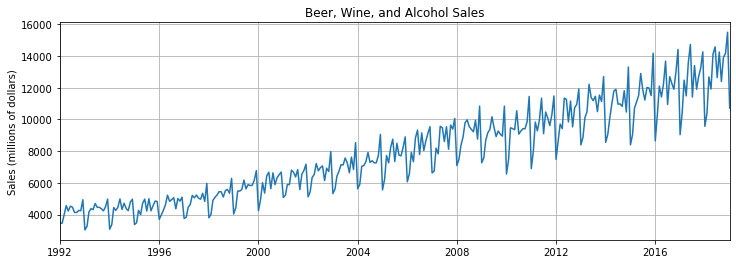

In [9]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.show()

In [10]:
y = df['S4248SM144NCEN'].values.astype(float)

# Define a test size
test_size = 12

# Create train and test sets
train_set = y[:-test_size]
test_set = y[-test_size:]

In [11]:
test_set

array([10415., 12683., 11919., 14138., 14583., 12640., 14257., 12396.,
       13914., 14174., 15504., 10718.])

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

In [13]:
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

In [14]:
train_norm.min()

-1.0

In [15]:
train_norm.max()

1.0

In [16]:
train_norm.mean()

-0.2041940178388313

In [17]:
type(train_norm)

numpy.ndarray

In [18]:
# Convert train_norm from an array to a tensor
train_norm = torch.FloatTensor(train_norm).view(-1)

window_size = 12

def input_data(seq,ws):  # ws is the window size
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

# Apply the input_data function to train_norm
train_data = input_data(train_norm,window_size)
len(train_data)  # this should equal 325-12-12

301

In [19]:
train_data[0]

(tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
         -0.8128, -0.7901, -0.7933, -0.6743]),
 tensor([-1.]))

In [20]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        self.linear = nn.Linear(hidden_size,output_size)
        
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]  

In [21]:
torch.manual_seed(101)
model = LSTMnetwork()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

LSTMnetwork(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [22]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

   400
 40000
   400
   400
   100
     1
______
 41301


In [23]:
epochs = 100

import time
start_time = time.time()

for epoch in range(epochs):
    
    # extract the sequence & label from the training data
    for seq, y_train in train_data:
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.25310209
Epoch:  2 Loss: 0.37532014
Epoch:  3 Loss: 0.39027199
Epoch:  4 Loss: 0.34934705
Epoch:  5 Loss: 0.33085635
Epoch:  6 Loss: 0.33229983
Epoch:  7 Loss: 0.32670355
Epoch:  8 Loss: 0.32074136
Epoch:  9 Loss: 0.30653533
Epoch: 10 Loss: 0.29518044
Epoch: 11 Loss: 0.26934361
Epoch: 12 Loss: 0.25998521
Epoch: 13 Loss: 0.24665757
Epoch: 14 Loss: 0.22403948
Epoch: 15 Loss: 0.18602757
Epoch: 16 Loss: 0.18561246
Epoch: 17 Loss: 0.17209382
Epoch: 18 Loss: 0.25161767
Epoch: 19 Loss: 0.22557595
Epoch: 20 Loss: 0.17449248
Epoch: 21 Loss: 0.20236212
Epoch: 22 Loss: 0.20818113
Epoch: 23 Loss: 0.16646339
Epoch: 24 Loss: 0.17596811
Epoch: 25 Loss: 0.11981886
Epoch: 26 Loss: 0.09510354
Epoch: 27 Loss: 0.04497015
Epoch: 28 Loss: 0.06977511
Epoch: 29 Loss: 0.00583372
Epoch: 30 Loss: 0.10420544
Epoch: 31 Loss: 0.00130300
Epoch: 32 Loss: 0.01704546
Epoch: 33 Loss: 0.00454277
Epoch: 34 Loss: 0.01743382
Epoch: 35 Loss: 0.05319921
Epoch: 36 Loss: 0.01346177
Epoch: 37 Loss: 0.00281374
E

In [24]:
future = 12

preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

In [25]:
preds[window_size:] 

[0.23506034910678864,
 0.6260973215103149,
 0.41005903482437134,
 0.844787061214447,
 1.0400598049163818,
 0.39853256940841675,
 0.9456188082695007,
 0.5160020589828491,
 0.790351152420044,
 0.7850838303565979,
 0.7218895554542542,
 0.27887773513793945]

In [26]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions

array([[10255.4855121 ],
       [12542.85628217],
       [11279.14032421],
       [13822.08191457],
       [14964.32982886],
       [11211.71626475],
       [14411.89721897],
       [11898.85404402],
       [13503.65906608],
       [13472.84786567],
       [13103.19295463],
       [10511.79531169]])

In [27]:
df['S4248SM144NCEN'][-12:]

DATE
2018-02-01    10415
2018-03-01    12683
2018-04-01    11919
2018-05-01    14138
2018-06-01    14583
2018-07-01    12640
2018-08-01    14257
2018-09-01    12396
2018-10-01    13914
2018-11-01    14174
2018-12-01    15504
2019-01-01    10718
Name: S4248SM144NCEN, dtype: int64

In [28]:
x = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]').astype('datetime64[D]')
x

array(['2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
       '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
       '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01'],
      dtype='datetime64[D]')

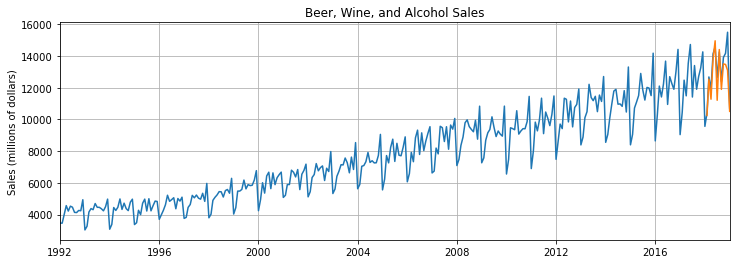

In [29]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions)
plt.show()

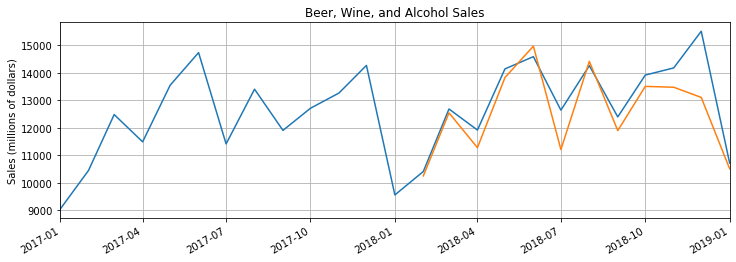

In [30]:
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()

plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_predictions)
plt.show()

In [31]:
epochs = 100

model.train()

y_norm = scaler.fit_transform(y.reshape(-1, 1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm,window_size)

import time
start_time = time.time()

for epoch in range(epochs):
    
    for seq, y_train in all_data:  
        
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.02637003
Epoch:  2 Loss: 0.02235967
Epoch:  3 Loss: 0.01420650
Epoch:  4 Loss: 0.01096698
Epoch:  5 Loss: 0.01132137
Epoch:  6 Loss: 0.01067625
Epoch:  7 Loss: 0.01385082
Epoch:  8 Loss: 0.01225379
Epoch:  9 Loss: 0.01069641
Epoch: 10 Loss: 0.01001978
Epoch: 11 Loss: 0.00892048
Epoch: 12 Loss: 0.00881878
Epoch: 13 Loss: 0.00787867
Epoch: 14 Loss: 0.00793300
Epoch: 15 Loss: 0.00654336
Epoch: 16 Loss: 0.00477153
Epoch: 17 Loss: 0.00421579
Epoch: 18 Loss: 0.00813891
Epoch: 19 Loss: 0.00435803
Epoch: 20 Loss: 0.00231854
Epoch: 21 Loss: 0.00287038
Epoch: 22 Loss: 0.00277172
Epoch: 23 Loss: 0.00316620
Epoch: 24 Loss: 0.00285987
Epoch: 25 Loss: 0.00255703
Epoch: 26 Loss: 0.00237400
Epoch: 27 Loss: 0.00013880
Epoch: 28 Loss: 0.00067541
Epoch: 29 Loss: 0.00265941
Epoch: 30 Loss: 0.00173528
Epoch: 31 Loss: 0.00183163
Epoch: 32 Loss: 0.00133842
Epoch: 33 Loss: 0.00051252
Epoch: 34 Loss: 0.00032429
Epoch: 35 Loss: 0.00007254
Epoch: 36 Loss: 0.00043622
Epoch: 37 Loss: 0.00015376
E

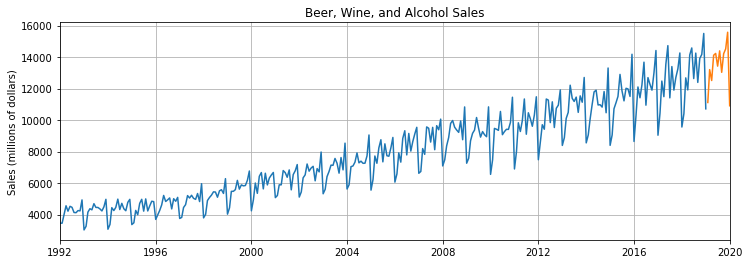

In [32]:
window_size = 12
future = 12
L = len(y)

preds = y_norm[-window_size:].tolist()

model.eval()
for i in range(future):  
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        # Reset the hidden parameters here!
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))  
        preds.append(model(seq).item())

true_predictions = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

x = np.arange('2019-02-01', '2020-02-01', dtype='datetime64[M]').astype('datetime64[D]')

plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions[window_size:])
plt.show()

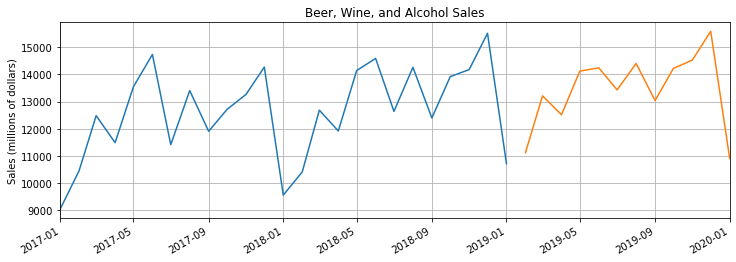

In [33]:
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_predictions[window_size:])
plt.show()